In [2]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

In [3]:
prod_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_SQL_CREDENTIALS'])))

In [4]:
query = '''
    select * from event_logs where event_type='DIRTY_LENS';
'''

edf = prod_access_utils.extract_from_database(query)

In [5]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [6]:
queryCache = {}

In [7]:
def getPenDF(pen):
    akpd_filter = 0.95

    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.akpd_score > %0.4f
        AND prod.biomass_computations.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], akpd_filter, pen['pen_id'])
    
    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    if len(df) == 0:
        return df
        
    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
#     depths = []
#     for idx, row in df.iterrows():
#         ann, cm = row.annotation, row.camera_metadata
#         wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
#         depth = np.median([wkp[1] for wkp in wkps.values()])
#         vector = wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']
#         depths.append(depth)
#     df['depth'] = depths
    
    return df


In [8]:
edf = edf.dropna()

In [9]:
edf

edf['pen_id'].astype('int')

0      61
1      86
2      60
3      85
4      86
     ... 
63     67
64    238
65    262
66    270
67    261
Name: pen_id, Length: 67, dtype: int64

In [10]:
import scipy.stats as stats

def get_norm_pct(dist, pct):
    percentile = np.percentile(dist, pct)
    return (percentile - np.mean(dist)) / np.std(dist)

def get_statistic(df1, df2):
    gt = []
    actual = []

    for pct in np.arange(0, 100, 1):
        gt.append(get_norm_pct(df1['estimated_weight_g'], pct))
        actual.append(get_norm_pct(df2['estimated_weight_g'], pct))

    res = stats.ks_2samp(gt, actual)
    pvalue = res.pvalue
    return pvalue

In [12]:
before_weight = []
before_end_weight = []
after_weight = []
after_end_weight = []
before_num_days = []
between_num_days = []
after_num_days = []
before_counts = []
before_end_counts = []
after_counts = []
after_end_counts = []
comp12s = []
comp13s = []
comp14s = []
comp23s = []
comp24s = []
comp34s = []

for index, event in edf.iterrows():
    pen = {
        'pen_id': int(event['pen_id']),
        'start_date': event['started_at'] - timedelta(days=7),
        'end_date': event['ended_at'] + timedelta(days=7)
    }

    df1 = getPenDF(pen)
    
    if len(df1) == 0:
        continue

    mask1 = (df1['captured_at'] < event['started_at'] - timedelta(days=5)) & (df1.hour > 9) & (df1.hour <= 15)
    mask2 = (df1['captured_at'] > event['started_at'] - timedelta(days=2)) & (df1['captured_at'] < event['started_at']) & (df1.hour > 9) & (df1.hour <= 15)
    mask3 = (df1['captured_at'] < event['ended_at'] + timedelta(days=2)) & (df1['captured_at'] > event['ended_at']) & (df1.hour > 9) & (df1.hour <= 15)
    mask4 = (df1['captured_at'] > event['ended_at'] + timedelta(days=5))  & (df1.hour > 9) & (df1.hour <= 15)
    
    if np.sum(mask1) < 100 or np.sum(mask2) < 100 or np.sum(mask3) < 100 or np.sum(mask4) < 100:
        continue
    
    before_days = (np.mean(df1[mask2]['captured_at']) - np.mean(df1[mask1]['captured_at'])).total_seconds() / 3600 / 24
    between_days = (np.mean(df1[mask3]['captured_at']) - np.mean(df1[mask2]['captured_at'])).total_seconds() / 3600 / 24
    after_days = (np.mean(df1[mask4]['captured_at']) - np.mean(df1[mask3]['captured_at'])).total_seconds() / 3600 / 24
    
    before = np.mean(df1[mask1]['estimated_weight_g'])
    before_end =  np.mean(df1[mask2]['estimated_weight_g'])
    after = np.mean(df1[mask3]['estimated_weight_g'])
    after_end =  np.mean(df1[mask4]['estimated_weight_g'])
    
    comp12s.append(get_statistic(df1[mask1], df1[mask2]))
    comp13s.append(get_statistic(df1[mask1], df1[mask3]))
    comp14s.append(get_statistic(df1[mask1], df1[mask4]))
    comp23s.append(get_statistic(df1[mask2], df1[mask3]))
    comp24s.append(get_statistic(df1[mask2], df1[mask4]))
    comp34s.append(get_statistic(df1[mask3], df1[mask4]))
    
    diff = after - before
    
    before_counts.append(np.sum(mask1))
    before_end_counts.append(np.sum(mask2))
    after_counts.append(np.sum(mask3))
    after_end_counts.append(np.sum(mask4))
    
    before_weight.append(before)
    before_end_weight.append(before_end)
    after_weight.append(after)
    after_end_weight.append(after_end)
    
    before_num_days.append(before_days)
    between_num_days.append(between_days)
    after_num_days.append(after_days)
    
    print(event['pen_id'], diff, before, after)

comp12s = np.array(comp12s)
comp13s = np.array(comp13s)
comp14s = np.array(comp14s)
comp23s = np.array(comp23s)
comp24s = np.array(comp24s)
comp34s = np.array(comp34s)
    
before_weight = np.array(before_weight)
before_end_weight = np.array(before_end_weight)
after_weight = np.array(after_weight)
after_end_weight = np.array(after_end_weight)
before_num_days = np.array(before_num_days)
between_num_days = np.array(between_num_days)
after_num_days = np.array(after_num_days)
before_counts = np.array(before_counts)
before_end_counts = np.array(before_end_counts)
after_counts = np.array(after_counts)
after_end_counts = np.array(after_end_counts)

86.0 165.29095242585345 2224.976248496416 2390.2672009222692
60.0 105.18924308302485 2751.3184231857254 2856.50766626875
85.0 124.72534303681778 1250.4145434765346 1375.1398865133524
86.0 241.2017056501004 2458.6836222070156 2699.885327857116
119.0 44.90376245183643 2320.662902307014 2365.5666647588505
85.0 72.83191086981367 781.6809856391261 854.5128965089398
1.0 168.67576839638912 696.2518869115295 864.9276553079186
86.0 257.80738966836316 2795.7329985494143 3053.5403882177775
5.0 264.1102304022427 1558.1670921071138 1822.2773225093565
127.0 309.49146786222195 1542.95151414011 1852.442982002332
126.0 222.42572253100525 1551.2807136131387 1773.706436144144
132.0 63.35823006248074 2123.2939244255977 2186.6521544880784
131.0 142.91065877259916 4028.161758556962 4171.072417329561
1.0 195.00947429073005 1012.9233862058726 1207.9328604966026
60.0 -207.14092973739298 3647.4401157059738 3440.299185968581
131.0 384.0661580948972 4171.072417329561 4555.138575424458
86.0 302.65374256127507 3219

In [13]:
(event['ended_at'] - event['started_at']).total_seconds() / 3600 / 24

3.4583449074074077

In [14]:
print(np.mean(comp12s))
print(np.mean(comp13s))
print(np.mean(comp14s))
print(np.mean(comp23s))
print(np.mean(comp24s))
print(np.mean(comp34s))

0.9846808893194658
0.9869104889008841
0.9787075993087179
0.9770742808211477
0.9811677086452918
0.9866043807561549


(array([ 1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  1., 36.]),
 array([0.81541471, 0.83387324, 0.85233177, 0.8707903 , 0.88924883,
        0.90770736, 0.92616588, 0.94462441, 0.96308294, 0.98154147,
        1.        ]),
 <a list of 10 Patch objects>)

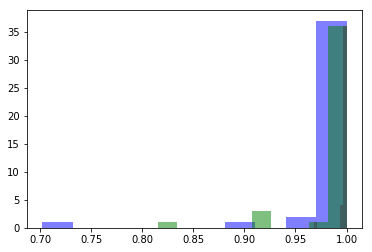

In [15]:
mask = comp12s > 0.9

plt.hist(comp12s[mask], alpha = 0.5, color = 'red')
plt.hist(comp13s[mask], alpha = 0.5, color = 'blue')
plt.hist(comp14s[mask], alpha = 0.5, color = 'green')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 39.]),
 array([0.58300906, 0.62470816, 0.66640725, 0.70810634, 0.74980544,
        0.79150453, 0.83320362, 0.87490272, 0.91660181, 0.95830091,
        1.        ]),
 <a list of 10 Patch objects>)

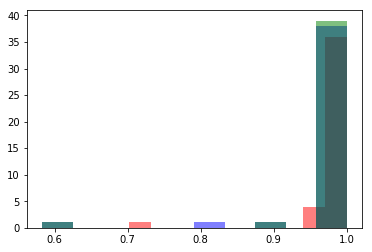

In [16]:
plt.hist(comp23s[mask], alpha = 0.5, color = 'red')
plt.hist(comp24s[mask], alpha = 0.5, color = 'blue')
plt.hist(comp34s[mask], alpha = 0.5, color = 'green')

0.0072810711872705455 0.00594987750061689 0.006503115811186319


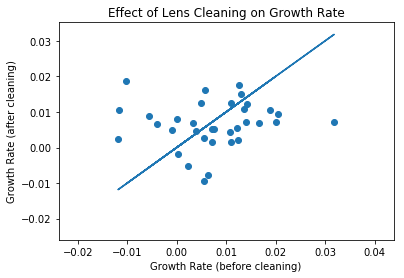

In [17]:
diff1 = before_end_weight - before_weight
diff2 = after_end_weight - after_weight
diff3 = after_weight - before_end_weight

mask = (before_counts > 250) & (before_end_counts > 250) & (after_counts > 250) & (after_end_counts > 250)

before_growth_rate = diff1[mask] / before_num_days[mask] / before_weight[mask]
between_growth_rate = diff3[mask] / between_num_days[mask] / before_weight[mask]
after_growth_rate = diff2[mask] / after_num_days[mask] / after_weight[mask]

plt.scatter(before_growth_rate, after_growth_rate)
plt.plot(before_growth_rate, before_growth_rate)
plt.xlabel('Growth Rate (before cleaning)')
plt.ylabel('Growth Rate (after cleaning)')
plt.title('Effect of Lens Cleaning on Growth Rate')

print(np.mean(before_growth_rate), np.mean(between_growth_rate), np.mean(after_growth_rate))

In [18]:
plt.hist(growth_rate, bins = 20)

NameError: name 'growth_rate' is not defined